In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
i = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        i += 1
        
        if i == 20:
            break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-wheat-detection/sample_submission.csv
/kaggle/input/global-wheat-detection/train.csv
/kaggle/input/global-wheat-detection/test/796707dd7.jpg
/kaggle/input/global-wheat-detection/test/2fd875eaa.jpg
/kaggle/input/global-wheat-detection/test/cc3532ff6.jpg
/kaggle/input/global-wheat-detection/test/53f253011.jpg
/kaggle/input/global-wheat-detection/test/f5a1f0358.jpg
/kaggle/input/global-wheat-detection/test/51f1be19e.jpg
/kaggle/input/global-wheat-detection/test/aac893a91.jpg
/kaggle/input/global-wheat-detection/test/cb8d261a3.jpg
/kaggle/input/global-wheat-detection/test/51b3e36ab.jpg
/kaggle/input/global-wheat-detection/test/348a992bb.jpg
/kaggle/input/global-wheat-detection/train/944c60a15.jpg
/kaggle/input/global-wheat-detection/train/dd5dd0234.jpg
/kaggle/input/global-wheat-detection/train/72f8aaa4f.jpg
/kaggle/input/global-wheat-detection/train/69595016d.jpg
/kaggle/input/global-wheat-detection/train/28b8ba0aa.jpg
/kaggle/input/global-wheat-detection/train/2d6357

* Faster RCNN from torchvision
* Use Resnet50 backbone
* Albumentation enabled (simple flip for now)

## study  
`backbone & pretrained`?

In [2]:
import cv2
import os
import re
from PIL import Image
import albumentations as al
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler # what?

import matplotlib.pyplot as plt
import matplotlib.patches as patches

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [3]:
train_df = pd.read_csv(f'{DIR_TRAIN}.csv')
train_df.shape

(147793, 5)

In [4]:
train_df[['x','y','w','h']] = -1

In [5]:
def expand_bbox(x):
    r = np.array(re.findall('[0-9]+[.]?[0-9]*', x))
    if len(r) == 0:
        r = [-1,-1,-1,-1]
    return r

train_df[['x','y','w','h']] = np.stack(train_df['bbox'].apply(expand_bbox)).astype(np.float32)
train_df.head()

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


In [6]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]
train_df.shape, valid_df.shape

((122787, 9), (25006, 9))

In [7]:
class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index: int):    
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x','y','w','h']].values
        boxes[:,2] += boxes[:,0]
        boxes[:,3] += boxes[:,1]
        
        area = (boxes[:,3]-boxes[:,1]) * (boxes[:,2]-boxes[:,0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['area'] = area
        target['labels'] = labels
        target['iscrowd'] = iscrowd
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        
        if self.transforms:
            sample = {
                'image' : image,
                'bboxes' : target['boxes'],
                'labels' : labels
            }
            sample = self.transforms(**sample) 
            image = sample['image'] # 변환 후 재할당
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            
        return image, target, image_id
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

```py
class Compose(BaseCompose):
```
Compose transforms and handle all transformations regrading bounding boxes  
  
Args:  
`transforms (list)` : list of transformations to compose.  
`bbox_params (dict)` : Parameters for bounding boxes transforms  
`additional_targets (dict)` : Dict with keys - new target name, values - old target name. ex: {'image2': 'image'}  
`p (float)`: probability of applying all list of transforms. Default: 1.0.  

**bbox_params**   
dictionary contains the following keys:  
* **format** (*str*):  
format of bounding boxes. Should be 'coco', 'pascal_voc' or 'albumentations'.  
If None - don't use bboxes.  

The `coco` format of a bounding box looks like `[x_min, y_min, width, height]`, e.g. [97, 12, 150, 200].  
The `pascal_voc` format of a bounding box looks like `[x_min, y_min, x_max, y_max]`, e.g. [97, 12, 247, 212].  
The `albumentations` format of a bounding box looks like `pascal_voc`, but between [0, 1], in other words: [x_min, y_min, x_max, y_max], e.g. [0.2, 0.3, 0.4, 0.5].    

* | **label_fields** (*list*): list of fields that are joined with boxes, e.g labels.
| Should be same type as boxes.
* | **min_area** (*float*): minimum area of a bounding box. All bounding boxes whose
| visible area in pixels is less than this value will be removed. Default: 0.0.
* | **min_visibility** (*float*): minimum fraction of area for a bounding box
| to remain this box in list. Default: 0.0.
    """


In [8]:
# Albumentations
def get_train_transform():
    return al.Compose([ToTensorV2(p=1.0)], 
                      bbox_params = {'format':'pascal_voc', 'label_fields':['labels']})
    
def get_valid_transform():
    return al.Compose([ToTensorV2(p=1.0)], 
                      bbox_params = {'format':'pascal_voc', 'label_fields':['labels']})

## Create the model

In [9]:
# load a model ; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [10]:
num_classes = 2 # 1 class (wheat) + 0 background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
# loss function
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
        
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
        
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist() # = 인덱스 랜덤 섞기

train_data_loader = DataLoader(train_dataset, 
                               batch_size = 8,
                               shuffle = False,
                               num_workers = 4,
                               collate_fn = collate_fn)
valid_data_loader = DataLoader(valid_dataset,
                               batch_size = 8,
                               shuffle = False,
                               num_workers = 4,
                               collate_fn = collate_fn)

# collate_fn : merges a list of samples to form a mini-batch of Tensor(s). 
# Used when using batched loading from a map-style dataset.

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Sample

In [14]:
images, targets, image_ids = next(iter(train_data_loader))
images = [image.to(device) for image in images]
targets = [{key:value.to(device) for key, value in target.items()} for target in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

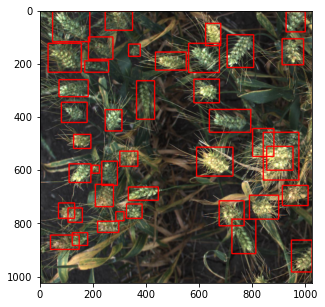

In [15]:
plt.figure(figsize=(5,5))

for box in boxes:
    cv2.rectangle(sample, 
                  (box[0], box[1]),
                  (box[2], box[3]), 
                  (255,0,0), 3)
plt.imshow(sample);

## Train

In [16]:
model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 1e-3, momentum = 0.9)
lr_scheduler = None
num_epochs = 1

In [17]:
loss_hist = Averager()
itr = 0
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value) # current_total + loss_value
        
        optimizer.zero_grad() # 옵티마이저 초기화
        losses.backward()     # loss 에 기반한 역전파 (loss_dict 클래스에 기반)
        optimizer.step()      # 옵티마이저 갱신
        
        if itr % 50 == 0:
            print(f'Iteration # {itr} loss : {loss_value}')
        itr += 1
        
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    print(f'\nEpoch # {epoch} loss : {loss_hist.value}\n')

Iteration # 0 loss : 5.665439671567111
Iteration # 50 loss : 1.099117383793533
Iteration # 100 loss : 1.0731013374945488
Iteration # 150 loss : 0.9699351664395339
Iteration # 200 loss : 0.9438707443216281
Iteration # 250 loss : 0.7330474646866589
Iteration # 300 loss : 0.8149115107287584

Epoch # 0 loss : 1.0268432325071628



In [18]:
loss_dict

{'loss_classifier': tensor(0.2281, device='cuda:0', grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.4386, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0615, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0963, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)}

In [19]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)
targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

boxes = targets[4]['boxes'].cpu().numpy().astype(np.int32)
sample = images[4].permute(1,2,0).cpu().numpy()

model.eval()
cpu_device = torch.device('cpu')

outputs = model(images)
targets = [{k:v.to(cpu_device) for k,v in t.items()} for t in outputs]

In [20]:
targets[4]['boxes'][0]

tensor([866.7612, 415.2690, 954.9674, 507.5633], grad_fn=<SelectBackward>)

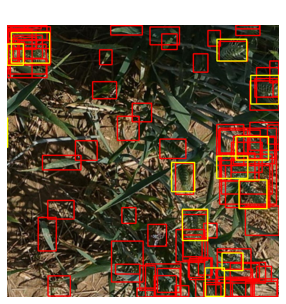

In [21]:
plt.figure(figsize=(5,5))
for xmin, ymin, xmax, ymax in targets[4]['boxes']:
    cv2.rectangle(sample, (xmin, ymin), (xmax, ymax), (255,0,0), 3)

for xmin, ymin, xmax, ymax in boxes:
    cv2.rectangle(sample, (xmin, ymin), (xmax, ymax), (255,255,0), 3)

plt.imshow(sample)
plt.axis('off')
plt.title('infer : red, answer : yellow', fontsize= 16, fontweight='bold', loc= 'left', color='white')
plt.show();

## Test

In [22]:
test_df = pd.read_csv("/kaggle/input/global-wheat-detection/sample_submission.csv")
test_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [23]:
class WheatTestDataset(Dataset):
    def __init__(self,dataframe, image_dir, transforms = None):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index:int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(f'{dir_test}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transforms:
            sample = {
                'image' : image,
                
            }
            sample = self.transforms(**sample)
            image = sample['image']
        
        return image, image_id
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [26]:
def get_test_transform():
    return al.Compose([ToTensorV2(p = 1.0)])

In [30]:
dir_test = '/kaggle/input/global-wheat-detection/test'
test_dataset = WheatTestDataset(test_df, 
                                dir_test,
                                transforms = get_test_transform())

test_data_loader = DataLoader(test_dataset,
                              batch_size = 8,
                              shuffle = False,
                              num_workers = 4,
                              collate_fn = collate_fn)

In [32]:
def format_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append(f'{j[0]:.4f} {j[1][0]} {j[1][1]} {j[1][2]} {j[1][3]}')
    return " ".join(pred_strings)

In [34]:
detection_threshold = 0.5
results = []
for images, image_ids in test_data_loader:
    images = list(image.to(device) for image in images)
    outputs = model(images)
    
    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        
        image_id = image_ids[i]
        
        boxes[:, 2] -= boxes[:, 0]
        boxes[:, 3] -= boxes[:, 1]
        
        result = {
            'image_id' : image_id,
            'PredictionString' : format_string(boxes, scores)
        }
        results.append(result)
print('Prediction Done!')

Prediction Done!


In [36]:
submission = pd.DataFrame(results)
submission.to_csv("submission.csv", index=0)
submission

,image_id,PredictionString
0,aac893a91,0.9816 66 2 101 153 0.9776 691 389 119 168 0.9...
1,51f1be19e,0.9651 283 468 133 113 0.9605 762 872 155 107 ...
2,f5a1f0358,0.9623 689 195 114 93 0.9584 544 268 111 108 0...
3,796707dd7,0.9665 709 822 104 96 0.9466 940 65 80 106 0.9...
4,51b3e36ab,0.9759 873 283 150 140 0.9734 358 144 107 101 ...
5,348a992bb,0.9835 535 29 83 94 0.9833 142 32 112 83 0.982...
6,cc3532ff6,0.9896 366 0 91 96 0.9811 491 573 91 131 0.976...
7,2fd875eaa,0.9813 727 882 98 87 0.9799 393 790 73 83 0.97...
8,cb8d261a3,0.9646 167 899 83 83 0.9612 534 516 101 59 0.9...
9,53f253011,0.9745 934 199 89 133 0.9649 20 27 139 105 0.9...


In [ ]:
# default
# torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False, pretrained_backbone = True) 